In [75]:
import math
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import metrics
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from IPython.display import clear_output

import seaborn as sns
from sklearn.model_selection import cross_val_score

In [13]:
df = pd.read_csv('./training.zip')
df_test = pd.read_csv('./test.zip')
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [14]:
df_nan = df.replace(-999, np.nan)
df_notna = df_nan[(df_nan['PRI_jet_leading_pt'].isna() == False) & (df_nan['DER_deltaeta_jet_jet'].isna() == False) & (df_nan['DER_mass_MMC'].isna() == False)]
df_notna.shape

(68114, 33)

In [15]:
df_notna['Label'].value_counts()

Label
b    36220
s    31894
Name: count, dtype: int64

In [214]:
X = df_notna.values[:, :-2]
y = df_notna['Label'].map({'s': 1, 'b': 0}).values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=314)

## Построение модели для предсказания целевой переменной сигнала для частиц

In [215]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [216]:
X_train_tensor = torch.from_numpy(X_train_scaled.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_scaled.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))
X_val_tensor = torch.from_numpy(X_val_scaled.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [217]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [218]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation  values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("F1-score")
    plt.show()


def train_and_validate(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    num_epochs,
    threshold,
    verbose=True,
):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                predictions_binary = (predictions >= threshold).type(torch.int)
                metric_value = metrics.f1_score(predictions_binary.cpu().numpy(), y_batch.cpu().numpy())
                if isinstance(metric_value, torch.Tensor):
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "F1": metric_value})

        train_losses.append(running_loss / len(train_loader.dataset))
        train_metrics.append(running_metric / len(train_loader.dataset))

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                predictions_binary = (predictions >= threshold).type(torch.int)
                metric_value = metrics.f1_score(predictions_binary.cpu().numpy(), y_batch.cpu().numpy())
                if isinstance(metric_value, torch.Tensor):
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "F1-score": metric_value})

        val_losses.append(running_loss / len(val_loader.dataset))
        val_metrics.append(running_metric / len(val_loader.dataset))

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f"Validation F1-score: {val_metrics[-1]:.3f}")

    return train_metrics[-1], val_metrics[-1]

def eval_model(model, dataloader, criterion, threshold):
    model.eval()
    running_loss, running_metric = 0, 0
    
    for X_batch, y_batch in dataloader:
        with torch.no_grad():
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            predictions_binary = (predictions >= threshold).type(torch.int)
            metric_value = metrics.f1_score(predictions_binary.cpu().numpy(), y_batch.cpu().numpy())
            if type(metric_value) == torch.Tensor:
                metric_value = metric_value.item()
                
            running_loss += loss.item() * X_batch.shape[0]
            running_metric += metric_value * X_batch.shape[0]
            
    test_loss = running_loss / len(dataloader.dataset)
    test_metric = running_metric / len(dataloader.dataset)
    return test_loss, test_metric

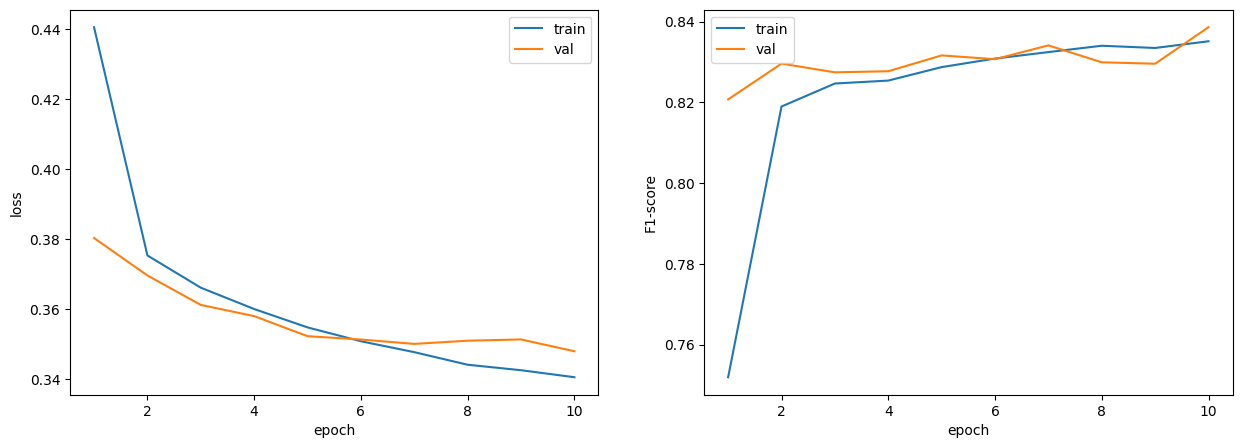

Validation F1-score: 0.839


(0.8351242753282916, 0.8385996035857064)

In [219]:
class BaselineNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BaselineNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.output(out))
        return out
        
# Обучение
input_dim = X.shape[1]
baseline_model = BaselineNetwork(input_dim).to(torch.device('cpu'))

criterion = nn.BCELoss()
optimizer = optim.Adam(baseline_model.parameters())

train_metric_nn, val_metric_nn = train_and_validate(baseline_model, optimizer, criterion, train_loader, val_loader, 10, 0.5)
train_metric_nn, val_metric_nn

## Выстраиваем более сложную архитектуру, пытаемся добиться лучших значений метрики

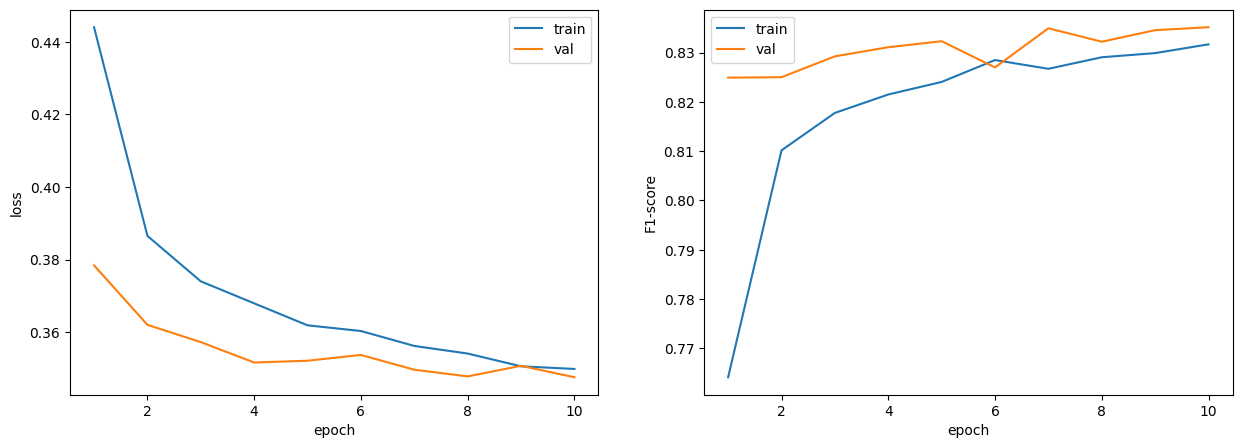

Validation F1-score: 0.835


(0.8316697824125261, 0.8351434511488083)

In [220]:
class FinalNetwork(nn.Module):
    def __init__(self, input_dim):
        super(FinalNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.sigmoid(self.output(out))
        return out

# Обучение
input_dim = X.shape[1]
final_model = FinalNetwork(input_dim).to(torch.device('cpu'))

criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters())

train_metric_nn, val_metric_nn = train_and_validate(final_model, optimizer, criterion, train_loader, val_loader, 10, 0.5)
train_metric_nn, val_metric_nn

In [221]:
test_loss_nn, test_mse_nn = eval_model(final_model, test_loader, criterion, 0.5)
test_loss_nn, test_mse_nn

(0.35079458299243554, 0.8246470627544897)

In [226]:
final_model.eval()
predictions = []
with torch.no_grad():
    for data in test_loader:
        X_batch = data[0].to(device)
        output = final_model(X_batch)
        predictions.extend(output.cpu().numpy()) 

print(len(predictions))

13623


In [233]:
y_pred_final = (np.array(predictions) > 0.5).astype(int)

In [234]:
metrics.f1_score(y_tree_target, y_pred_final)

0.8271931936752548

In [235]:
metrics.accuracy_score(y_tree_target, y_pred_final)

0.841958452616898

## Альтернативное решение задачи через предсказание веса частиц и последующее предсказание сигнала по весу

In [163]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("MSE")
    plt.show()


def train_and_validate(
    model,
    optimizer,
    criterion,
    metric,
    train_loader,
    val_loader,
    num_epochs,
    verbose=True,
):
    """
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    """
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f"Validation MSE: {val_metrics[-1]:.3f}")

    return train_metrics[-1], val_metrics[-1]

In [164]:
X = df_notna.values[:, :-2]
y = df_notna['Weight'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=314)

In [165]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [166]:
X_train_tensor = torch.from_numpy(X_train_scaled.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_scaled.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))
X_val_tensor = torch.from_numpy(X_val_scaled.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [167]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

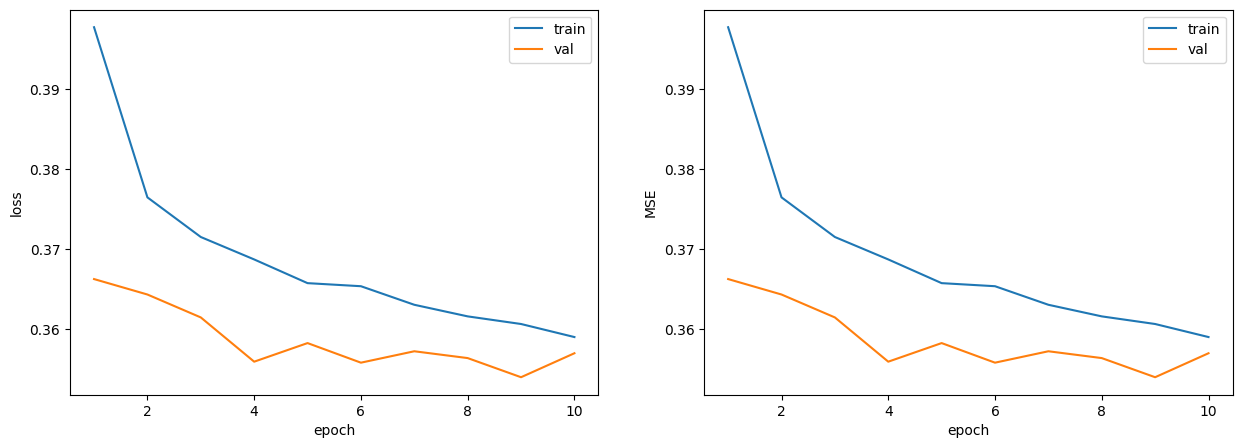

Validation MSE: 0.357


(0.3589704250289576, 0.35694353687007424)

In [204]:
class WeightModelNetwork(nn.Module):
    def __init__(self, input_dim):
        super(WeightModelNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.relu(self.fc3(out))
        out = self.dropout(out)
        out = self.sigmoid(self.output(out))
        return out

input_dim = X.shape[1]
weight_model = WeightModelNetwork(input_dim).to(torch.device('cpu'))

mse_metric = lambda pred, target: ((pred - target) ** 2).mean().item()
criterion = nn.MSELoss()

optimizer = optim.Adam(weight_model.parameters(), lr=1e-3)

train_mse_nn, val_mse_nn = train_and_validate(weight_model, optimizer, criterion, mse_metric, train_loader, val_loader, 10)
train_mse_nn, val_mse_nn

In [205]:
X_tree = df_notna['Weight'].values.reshape(-1,1)
y_tree = df_notna['Label'].map({'s': 1, 'b': 0}).values.reshape(-1,1)
_, _, X_tree_target, y_tree_target = train_test_split(X_tree, y_tree, test_size=0.2, random_state=314)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_tree, y_tree)

In [206]:
weight_model.eval()
weight_predictions = []
with torch.no_grad():
    for data in test_loader:
        X_batch = data[0].to(device)
        output = weight_model(X_batch)
        weight_predictions.extend(output.cpu().numpy()) 

print(len(weight_predictions))

13623


In [207]:
y_pred = clf.predict(weight_predictions)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(13623,))

In [208]:
metrics.f1_score(y_tree_target, y_pred)

0.574778130820642

In [209]:
metrics.accuracy_score(y_tree_target, y_pred)

0.715114145195625

## Итоги:

Лучшее качество было получено в случае предсказания непосредственно целевой переменной сигнала а не веса частиц.　 